# Captcha Recogniton using CRNN

Implementation of Convolutional Recurrent Nerual Network for Captcha Recognition.

Dataset:
[CAPTCHA Images](https://www.kaggle.com/fournierp/captcha-version-2-images)

Research Paper:
[An End-to-End Trainable Neural Network for Image-based Sequence
Recognition and Its Application to Scene Text Recognition
](https://arxiv.org/pdf/1507.05717.pdf)

## Setup

In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
tf.__version__

'2.6.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 64

## Load Dataset

In [5]:
data_dir = Path("dataset/")

In [6]:
data_path = list(map(str,list(data_dir.glob("*.png"))))
data_path[:10]

['dataset\\226md.png',
 'dataset\\22d5n.png',
 'dataset\\2356g.png',
 'dataset\\23mdg.png',
 'dataset\\23n88.png',
 'dataset\\243mm.png',
 'dataset\\244e2.png',
 'dataset\\245y5.png',
 'dataset\\24f6w.png',
 'dataset\\24pew.png']

In [7]:
labels = [path.split(os.path.sep)[-1].split(".png")[0] for path in data_path]
labels[:10]

['226md',
 '22d5n',
 '2356g',
 '23mdg',
 '23n88',
 '243mm',
 '244e2',
 '245y5',
 '24f6w',
 '24pew']

In [8]:
MAX_SEQ_LEN = max([len(label) for label in labels])

In [9]:
characters = set("".join(labels))
characters

{'2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'm',
 'n',
 'p',
 'w',
 'x',
 'y'}

In [10]:
def load_img(path):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation=cv.INTER_AREA)
    img = np.expand_dims(img, axis=2)
    img = img/255.
    return img

In [11]:
images = [load_img(path) for path in data_path]

226md
(64, 256, 1)


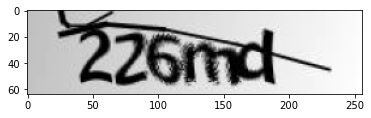

In [12]:
print(labels[0])
img = images[0]
print(img.shape)
plt.imshow(img,cmap='gray')

## Perprocessing

In [13]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary = list(characters),
    mask_token = None
)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.05, random_state=42, shuffle=True)

In [15]:
def encode_sample(img, label):
    img = tf.transpose(img, perm=[1,0,2])
    label = tf.convert_to_tensor(label)
    return {"image":img, "label":label}

In [16]:
def encode_labels(label):
    label = tf.strings.unicode_split(label ,input_encoding="UTF-8")
    label = char_to_num(label)
    label = list(label.numpy())
    label = tf.keras.preprocessing.sequence.pad_sequences([label], maxlen=MAX_SEQ_LEN, padding='post', value=len(characters))
    label = label[0]
    return label

In [17]:
y_train = [encode_labels(label) for label in y_train]

## Create Dataset

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=42,shuffle=True)

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = (
    train_dataset.map(encode_sample,num_parallel_calls=tf.data.AUTOTUNE)
).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val))
val_dataset = (
    val_dataset.map(encode_sample,num_parallel_calls=tf.data.AUTOTUNE)
).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
len(train_dataset),len(val_dataset)

(223, 25)

In [21]:
for batch in train_dataset.take(1):
    print(batch['image'][0].shape)
    print(batch['label'])

(256, 64, 1)
tf.Tensor(
[[ 2 17  9  8  1]
 [ 8 18 18  2 18]
 [ 9 19 19  2 11]
 [ 4 12  7 17  2]], shape=(4, 5), dtype=int32)


## Model

In [22]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred

In [23]:
def build_model():
    input_img = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    # Convolution Block 1
    x = layers.Conv2D(
        64,
        (3,3),
        activation="relu",
        padding="same",
        name="Conv1"
    )(input_img)
    x = layers.MaxPooling2D((2,2), name="pool1")(x)
    
    # Convolution Block 2
    x = layers.Conv2D(
        128,
        (3,3),
        activation="relu",
        padding="same",
        name="Conv2"
    )(x)
    x = layers.MaxPooling2D((2,2), name="pool2")(x)
    
    new_shape = ((IMG_WIDTH//4),(IMG_HEIGHT//4)*128)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.25)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    # Output Layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary())+1, activation='softmax', name='dense2'
    )(x)
    
    output = CTCLayer(name='ctc_loss')(labels, x)
    
    model = keras.models.Model(
        inputs = [input_img, labels], outputs=output, name='ocr_model'
    )
    
    model.compile(optimizer=keras.optimizers.Adam())
    return model

In [24]:
model = build_model()
model.summary()

Model: "ocr_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 64, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 128, 32, 64)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 128, 32, 128) 73856       pool1[0][0]                      
__________________________________________________________________________________________

## Training

In [25]:
EPOCHS = 200

EARLY_STOPPING_PATIENCE = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=EARLY_STOPPING_PATIENCE,restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/200
223/223 [==============================] - 17s 40ms/step - loss: 18.8190 - val_loss: 16.3950
Epoch 2/200
223/223 [==============================] - 7s 33ms/step - loss: 16.4417 - val_loss: 16.3542
Epoch 3/200
223/223 [==============================] - 7s 33ms/step - loss: 16.4149 - val_loss: 16.3521
Epoch 4/200
223/223 [==============================] - 7s 33ms/step - loss: 16.3864 - val_loss: 16.3616
Epoch 5/200
223/223 [==============================] - 7s 33ms/step - loss: 16.3178 - val_loss: 16.4887
Epoch 6/200
223/223 [==============================] - 7s 33ms/step - loss: 16.1704 - val_loss: 16.0656
Epoch 7/200
223/223 [==============================] - 7s 32ms/step - loss: 16.0485 - val_loss: 16.0144
Epoch 8/200
223/223 [==============================] - 7s 32ms/step - loss: 16.0036 - val_loss: 15.9935
Epoch 9/200
223/223 [==============================] - 7s 33ms/step - loss: 15.9837 - val_loss: 15.9778
Epoch 10/200
223/223 [==============================] - 7s 33ms

223/223 [==============================] - 7s 32ms/step - loss: 1.1256 - val_loss: 0.3726
Epoch 80/200
223/223 [==============================] - 7s 32ms/step - loss: 0.8629 - val_loss: 0.3291
Epoch 81/200
223/223 [==============================] - 7s 32ms/step - loss: 0.7182 - val_loss: 0.2064
Epoch 82/200
223/223 [==============================] - 7s 32ms/step - loss: 0.5752 - val_loss: 0.1757
Epoch 83/200
223/223 [==============================] - 7s 33ms/step - loss: 0.4243 - val_loss: 0.1436
Epoch 84/200
223/223 [==============================] - 7s 32ms/step - loss: 0.4709 - val_loss: 0.1169
Epoch 85/200
223/223 [==============================] - 7s 33ms/step - loss: 0.3805 - val_loss: 0.0836
Epoch 86/200
223/223 [==============================] - 7s 32ms/step - loss: 0.4044 - val_loss: 0.1182
Epoch 87/200
223/223 [==============================] - 7s 33ms/step - loss: 0.2783 - val_loss: 0.0513
Epoch 88/200
223/223 [==============================] - 7s 32ms/step - loss: 0.3345 - 

223/223 [==============================] - 7s 32ms/step - loss: 0.0431 - val_loss: 0.0011
Epoch 159/200
223/223 [==============================] - 7s 32ms/step - loss: 0.0887 - val_loss: 0.0029
Epoch 160/200
223/223 [==============================] - 7s 32ms/step - loss: 0.0889 - val_loss: 0.0095
Epoch 161/200
223/223 [==============================] - 7s 32ms/step - loss: 0.0439 - val_loss: 0.0022
Epoch 162/200
223/223 [==============================] - 7s 32ms/step - loss: 0.0335 - val_loss: 0.0011
Epoch 163/200
223/223 [==============================] - 7s 32ms/step - loss: 0.0170 - val_loss: 0.0017
Epoch 164/200
223/223 [==============================] - 7s 33ms/step - loss: 0.0388 - val_loss: 0.0012
Epoch 165/200
223/223 [==============================] - 7s 32ms/step - loss: 0.1335 - val_loss: 0.0032
Epoch 166/200
223/223 [==============================] - 7s 32ms/step - loss: 0.1373 - val_loss: 0.0033
Epoch 167/200
223/223 [==============================] - 7s 32ms/step - loss: 

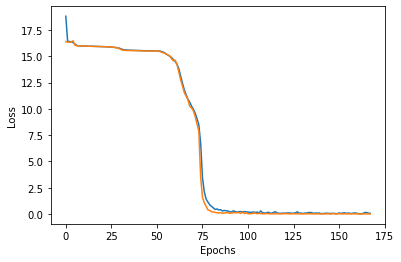

In [26]:
h = history.history
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Inference

In [27]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()
prediction_model.save('captch_recognition_model.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 256, 64, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 32, 64)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 128, 32, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 16, 128)       0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 2048)          0         
_________________________________________________________________
dense1 (Dense)               (None, 64, 64)            131136

In [28]:
def predict(x):
    x = tf.transpose(x, perm=[1,0,2])
    pred = prediction_model.predict(tf.convert_to_tensor([x]))
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:MAX_SEQ_LEN]
    output_text=[]
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text[0]

## Evaluation

In [29]:
def evaluate(X_test,y_test):
    matches = 0
    for x,y_true in zip(X_test,y_test):
        y_pred = predict(x)
        if y_pred == y_true:
            matches+=1
    return matches/len(y_test)

In [30]:
evaluate(X_test,y_test)

1.0

4fc36


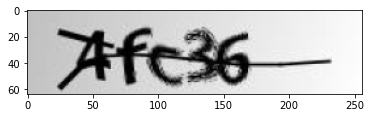

fyfbn


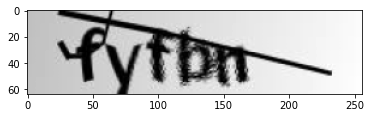

5mgn4


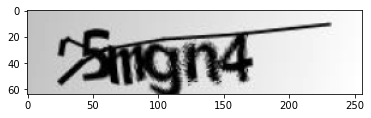

2mg87


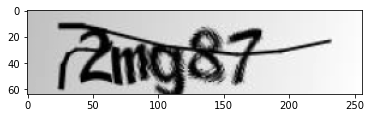

gw53m


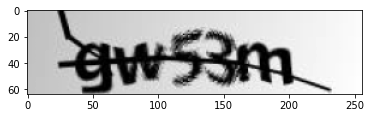

x2cnn


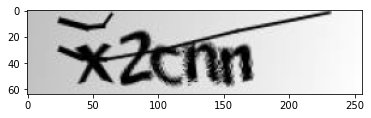

7bwm2


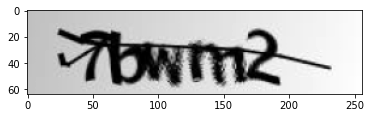

8684m


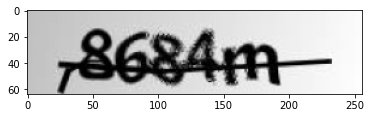

d66cn


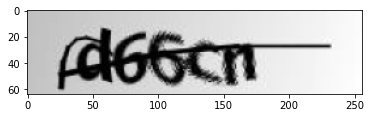

bd3b7


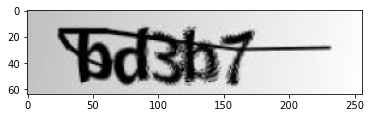

In [31]:
for i in range(10):
    print(y_test[i])
    plt.imshow(X_test[i],cmap='gray')
    plt.show()